# XGBoost Forecast

**Goal:**  

Utilize the XGBoost model to forecast the daily german electricity consumption in 2019 
 - Evaluation type: Offline / historical backtest  
 - Metric focus: MAE, RMSE, MAP 

**MLflow server:** 

mlflow server --backend-store-uri sqlite:///mlflow.db --host 127.0.0.1 --port 8080

**Author:** Rodrigo Amorim


## Import the necessary libraries and load the dataset

In [ ]:
# Load the Libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import optuna
import mlflow

from xgboost import XGBRegressor 
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set the tracking uri and give a name to the experiment (MLflow set up)
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("XGBoost_EnergyPrediction_Exp")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1766499984068, experiment_id='2', last_update_time=1766499984068, lifecycle_stage='active', name='XGBoost_EnergyPrediction_Exp', tags={}>

In [ ]:
# Load the Dataset
df = pd.read_parquet(r'C:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\Data\Processed/GermanEnergyConsumption.parquet')

In [ ]:
# Create the necessary features:
# Lag Features
lags = [1,24,48,72,168]

for lag in lags:
    df[f"lag_{lag}"] = df["DE_Load"].shift(lag)

# Time-based features 
df["hour"] = df.index.hour
df["dayoftheweek"] = df.index.dayofweek 

# Rolling Statistics 
df["rolling_mean_24"] = df["DE_Load"].shift(1).rolling(24).mean()
df["rolling_std_24"] = df["DE_Load"].shift(1).rolling(24).std()

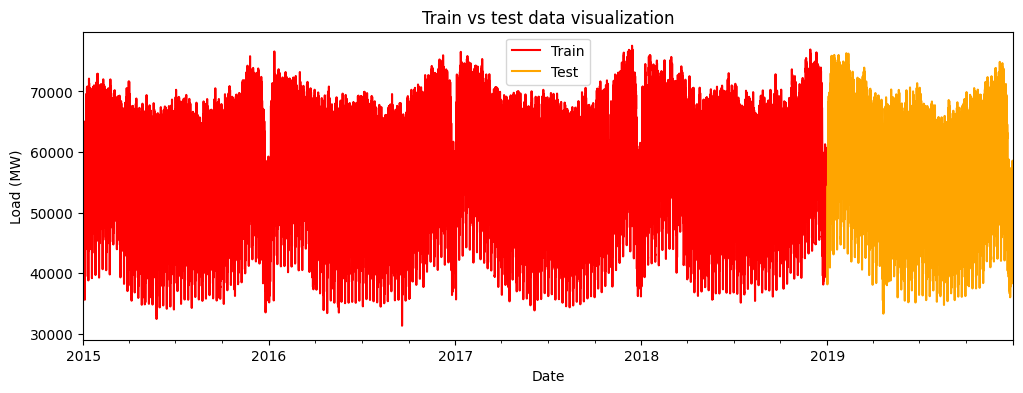

In [ ]:
# Train/Test Split 
# We will evaluate the model by predicting the next 24 hours repeatedly across the whole 2019 year (rolling-origin evaluation)
# Train (years) -> 2015/2016/2017/2018
# Test (years)  -> 2019

test_start_date = "2019-01-01"
train_df = df.loc[df.index < test_start_date]
test_df = df.loc[df.index >= test_start_date]

train_df["DE_Load"].plot(figsize=(12,4), title = "Train vs test data visualization",color = "red", xlabel = "Time", ylabel = "Load (MW)", label = "Train")
test_df["DE_Load"].plot(figsize=(12,4), color = "orange", label = "Test")
plt.gca().legend()
plt.show()

# Horizon of prediction 
Horizon = 24

## Hyperparameter tuning with Optuna

In [ ]:
# Hyperparameter tuning

X_train_full = train_df.drop(columns=["DE_Load"])
y_train_full = train_df["DE_Load"]

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample",0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "reg:squarederror",
        "random_state": 42 
    }

    model = XGBRegressor(**params)    

    tscv = TimeSeriesSplit(n_splits = 5)
    scores = []

    for train_idx, val_idx in tscv.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        scores.append(mean_absolute_error(y_val, preds))
    
    return np.mean(scores)

study = optuna.create_study(direction = "minimize", study_name = "Hyperparamater Tuning")
study.optimize(objective, n_trials = 50)


[I 2025-12-23 14:26:56,381] A new study created in memory with name: Hyperparamater Tuning
[I 2025-12-23 14:27:00,874] Trial 0 finished with value: 559.4414384678731 and parameters: {'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.15260841258530242, 'subsample': 0.6012600093061401, 'colsample_bytree': 0.8296777862437679, 'min_child_weight': 7}. Best is trial 0 with value: 559.4414384678731.
[I 2025-12-23 14:27:03,380] Trial 1 finished with value: 628.6218233979295 and parameters: {'n_estimators': 359, 'max_depth': 4, 'learning_rate': 0.03171718685214177, 'subsample': 0.9334913142412264, 'colsample_bytree': 0.9069411486555399, 'min_child_weight': 9}. Best is trial 0 with value: 559.4414384678731.
[I 2025-12-23 14:27:18,338] Trial 2 finished with value: 506.94576301548597 and parameters: {'n_estimators': 637, 'max_depth': 9, 'learning_rate': 0.044178278178268054, 'subsample': 0.6902874371772655, 'colsample_bytree': 0.9124430607361318, 'min_child_weight': 5}. Best is trial 2 with 

{'n_estimators': 714, 'max_depth': 10, 'learning_rate': 0.014714091016306035, 'subsample': 0.7394387606796536, 'colsample_bytree': 0.9504124979244586, 'min_child_weight': 8}


In [ ]:
# The best parameters
study.best_trial.params

{'n_estimators': 714,
 'max_depth': 10,
 'learning_rate': 0.014714091016306035,
 'subsample': 0.7394387606796536,
 'colsample_bytree': 0.9504124979244586,
 'min_child_weight': 8}

In [5]:
best_parameters = {
 'n_estimators': 714,
 'max_depth': 10,
 'learning_rate': 0.014714091016306035,
 'subsample': 0.7394387606796536,
 'colsample_bytree': 0.9504124979244586,
 'min_child_weight': 8,
 "objective" : "reg:squarederror",
 "random_state" : 42
 }

In [10]:
# Save the best parameters 
best_parameters = study.best_trial.params
best_parameters["objective"] = "reg:squarederror"
best_parameters["random_state"] = 42 

with mlflow.start_run(run_name = "Best_Parameters_XGBoost"):
    mlflow.log_params(best_parameters)

🏃 View run Best_Parameters_XGBoost at: http://127.0.0.1:8080/#/experiments/2/runs/aa3bab2f48954484a692d9f7b359c29c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/2


## Rolling window 2019 prediction and performance metrics computation

In [ ]:
# Rolling window 2019 prediction 

# Create empty lists to save the predictions, true values and timestamps 
rolling_predictions = []
rolling_targets = []
rolling_timestamps = []

train_rol_df = train_df.copy() # Create a copy of the original training set  

for start_time in test_df.index[::Horizon]:

    # The ideia is to refeed the model the previously used test data to mimic real world scenarios where the model is continuously updated with recent data
    end_time = start_time + pd.Timedelta(hours=Horizon)
    batch = test_df.loc[start_time: end_time - pd.Timedelta(hours=1)]

    if len(batch) < Horizon:
        break
    
    X_train = train_rol_df.drop(columns=["DE_Load"])
    y_train = train_rol_df["DE_Load"]


    model= XGBRegressor(
            **best_parameters
    )

    # Retrain the model
    model.fit(X_train, y_train)

    X_test_batch = batch.drop(columns=["DE_Load"])
    y_test_batch = batch["DE_Load"]


    # Make the predictions
    y_pred = model.predict(X_test_batch)

    # Save the results 
    rolling_predictions.extend(y_pred)
    rolling_targets.extend(y_test_batch.values)  
    rolling_timestamps.extend(y_test_batch.index)

    train_rol_df = pd.concat([train_rol_df, batch])    

In [ ]:
# Compute the performance metrics
mae = mean_absolute_error(rolling_targets, rolling_predictions)
rmse = root_mean_squared_error(rolling_targets, rolling_predictions)
map = mean_absolute_percentage_error(rolling_targets, rolling_predictions)

print(f"Rolling 24h MAE (full year): {mae:.2f}")
print(f"Rolling 24h RMSE (full year): {rmse: .2f}")
print(f"Rolling 24h MAP (full year): {map: .2f}")

Rolling 24h MAE (full year): 450.49
Rolling 24h RMSE (full year):  598.24
Rolling 24h MAP (full year):  0.01


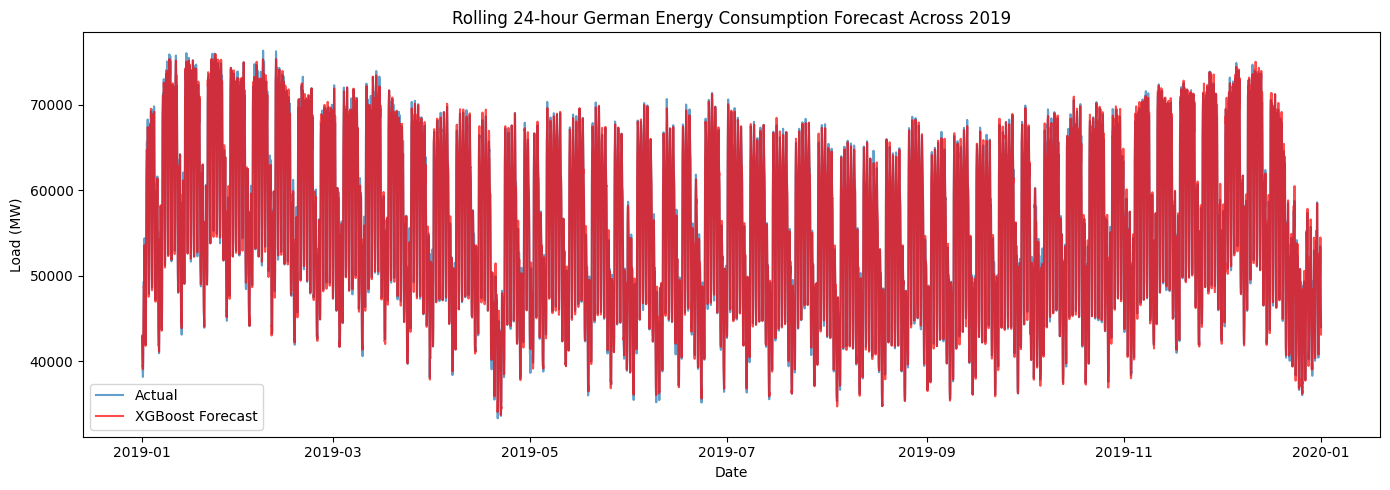

In [ ]:
# Forecast Plot 
plt.figure(figsize=(14, 5))
plt.plot(rolling_timestamps, rolling_targets, label="Actual", alpha=0.7)
plt.plot(rolling_timestamps, rolling_predictions, label="XGBoost Forecast", alpha=0.7, color = "red")
plt.legend()
plt.title("Rolling 24-hour German Energy Consumption Forecast Across 2019")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.show()

**Analysis:**

The XGBoost model demonstrates strong predictive performance for German electricity consumption in 2019. The rolling 24-hour evaluation yields a MAE of 450.49 MW and an RMSE of 598.24 MW, corresponding to approximately 0.8% and 1.1% of the average system load (considering values of around 55000 MW as the average), respectively. The MAPE of 1% further confirms the high accuracy of the model across the full year.

From the forecast plot, the model closely follows the actual load profile, successfully capturing daily, weekly, and seasonal consumption patterns. This indicates that the model has effectively learned the underlying temporal structure of electricity demand.

The slightly higher RMSE compared to MAE suggests the presence of occasional larger errors, which predominantly occur during periods of rapid load changes or extreme demand peaks. Such deviations are expected, as tree-based models tend to smooth sharp transitions and may struggle to fully capture rare events or sudden structural changes in demand.

Overall, the results indicate that XGBoost is a robust and reliable model for short-term electricity demand forecasting, with remaining errors primarily concentrated in high-variability periods.

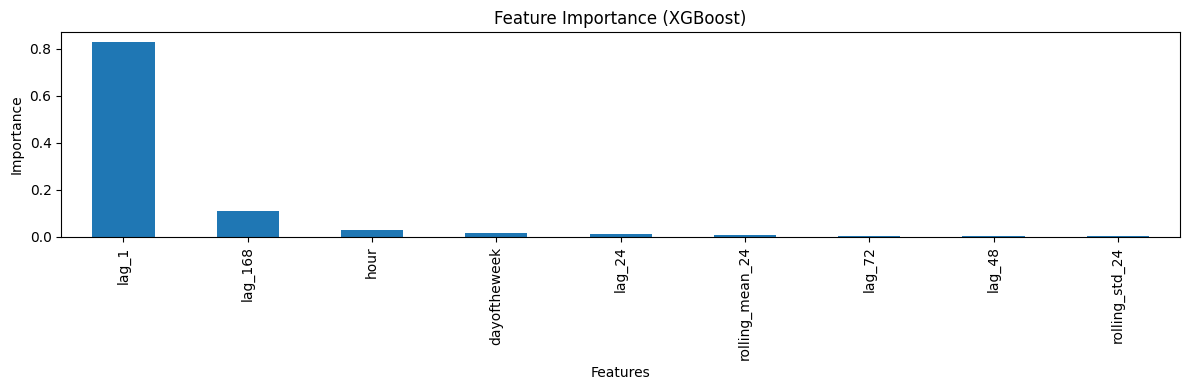

In [11]:
# Feature Importance 
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind = "bar", figsize=(12,4))
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

**Analysis:** 

As one can see from the feature importance plot above, the most important feature was the electricity consumption from the previous hour followed by the electricity consumption from the previous week. These results reinforce the idea that the electricity consumption in Germany demonstrates a highly daily and weekly seasonality patterns. 

In [12]:
# Save the results into mlflow 

y_pred_XGBoost = rolling_predictions 

with mlflow.start_run(run_name = "XGBoost_Results"):

    # Save the data first 
    np.save("y_pred_XGBoost.npy", y_pred_XGBoost)
    mlflow.log_artifact("y_pred_XGBoost.npy")    

🏃 View run XGBoost_Results at: http://127.0.0.1:8080/#/experiments/2/runs/8269c01fd1be4704921a2dfff10ee62c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/2
